In [1]:
from pathlib import Path
import json

from adjustText import adjust_text
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import pandas as pd
from cblearn.metrics import query_error

import datasets


sns.set_theme("paper", "whitegrid", font_scale=1.5)
plot_dir = Path('../plots')
plot_dir.mkdir(exist_ok=True)

## Plot datasets

In [2]:
data = datasets.fetch_all()
data = pd.DataFrame.from_records(data).transpose()
data['n_triplets'] = data.train_triplets.map(len)
data

,train_triplets,n_objects,n_triplets
car,"[[0, 27, 35], [48, 9, 23], [19, 42, 33], [19, ...",60,14194
food,"[[2, 48, 31], [65, 93, 72], [64, 43, 71], [0, ...",100,190376
imagenet-v1,"[[673, 918, 865], [673, 918, 546], [673, 918, ...",1000,328549
imagenet-v2,"[[25666, 35064, 37909], [25666, 35064, 30882],...",50000,4995601
material,"[[90, 22, 57], [67, 15, 26], [1, 16, 28], [37,...",100,92892
musician,"[[67, 92, 354], [279, 264, 366], [117, 296, 24...",448,131970
nature,"[[28, 16, 26], [31, 42, 43], [65, 10, 28], [10...",120,3355
things,"[[507, 1123, 278], [1161, 675, 919], [44, 392,...",1854,292024
vogue,"[[28, 6, 55], [35, 59, 16], [19, 49, 27], [8, ...",60,1107


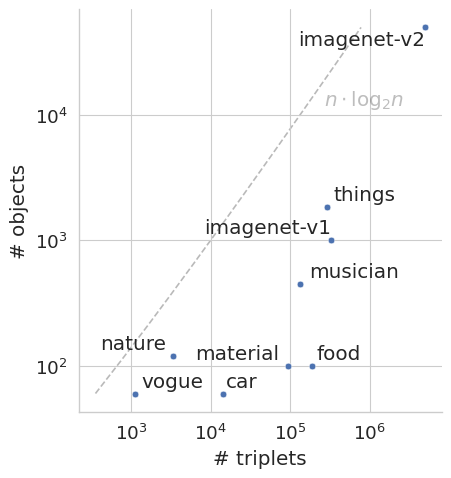

In [3]:
names = data.index
fg = sns.relplot(data, x='n_triplets', y='n_objects', legend=None)
fg.set(xlabel='# triplets', ylabel='# objects', xscale='log', yscale='log')

obj_space = np.linspace(np.min(data.n_objects), np.max(data.n_objects), 1000)
triplet_space = obj_space * np.log2(obj_space)
plt.plot(triplet_space, obj_space, 'k--', alpha=0.3, zorder=-1)    

labels = []
labels.append(plt.text(triplet_space[-700], obj_space[-800], f"$n\cdot \log_2 n$", alpha=0.3, horizontalalignment='left'))
labels = labels + [plt.text(x, y, name) for name, x, y in zip(names, data.n_triplets, data.n_objects)]
adjust_text(labels, expand_points=(1.2, 1.3))

fg.savefig(plot_dir / 'datasets.pdf')
fg.savefig(plot_dir / 'datasets.png')
plt.show()

## Load results

In [4]:
results = []
for r in Path('../results').glob('*.json'):
    with r.open('r') as f:
        d = json.load(f)
        if isinstance(d, list) and len(d) == 1:
            d = d[0]

    d['error'] = query_error(data.loc[d['dataset'], 'train_triplets'], np.array(d['embedding']))
    del d['embedding']
    if d['library'] == 'cblearn':
        d['name'] = f"{d['algorithm']} (ours)"
    elif d['library'] == 'loe':
        d['name'] = f"{d['algorithm']} (loe)"
    elif d['library'] == 'vanderMaaten':
        d['name'] = f"{d['algorithm']} (STE)"
    else:
        d['name'] = f"{d['algorithm']}"

    results.append(d)
    
results = pd.DataFrame.from_records(results)
results = results.join(data, on='dataset')


In [5]:
results['is_gpu'] = results.algorithm.str.endswith('-GPU')
results['algorithm'] = results.algorithm.str.replace('-GPU', '')
results

,dataset,library,algorithm,loss,cpu_time,_row,error,name,train_triplets,n_objects,n_triplets,is_gpu
0,car,loe,SOE,85.137300,0.976000,elapsed,0.191489,SOE (loe),"[[0, 27, 35], [48, 9, 23], [19, 42, 33], [19, ...",60,14194,False
1,food,loe,SOE,996.951000,8.733000,elapsed,0.185155,SOE (loe),"[[2, 48, 31], [65, 93, 72], [64, 43, 71], [0, ...",100,190376,False
2,imagenet-v1,loe,SOE,2300.321700,327.033000,elapsed,0.245081,SOE (loe),"[[673, 918, 865], [673, 918, 546], [673, 918, ...",1000,328549,False
3,material,loe,SOE,360.992400,6.159000,elapsed,0.149173,SOE (loe),"[[90, 22, 57], [67, 15, 26], [1, 16, 28], [37,...",100,92892,False
4,musician,loe,SOE,941.155800,54.901000,elapsed,0.298378,SOE (loe),"[[67, 92, 354], [279, 264, 366], [117, 296, 24...",448,131970,False
...,...,...,...,...,...,...,...,...,...,...,...,...
109,material,cblearn,tSTE,25313.772927,2.679793,NaN,0.125673,tSTE (ours),"[[90, 22, 57], [67, 15, 26], [1, 16, 28], [37,...",100,92892,False
110,musician,cblearn,tSTE,83667.003573,14.585133,NaN,0.329469,tSTE (ours),"[[67, 92, 354], [279, 264, 366], [117, 296, 24...",448,131970,False
111,nature,cblearn,tSTE,1970.642869,0.254311,NaN,0.295678,tSTE (ours),"[[28, 16, 26], [31, 42, 43], [65, 10, 28], [10...",120,3355,False
112,things,cblearn,tSTE,220475.075740,28.771954,NaN,0.432934,tSTE (ours),"[[507, 1123, 278], [1161, 675, 919], [44, 392,...",1854,292024,False


## Plot results

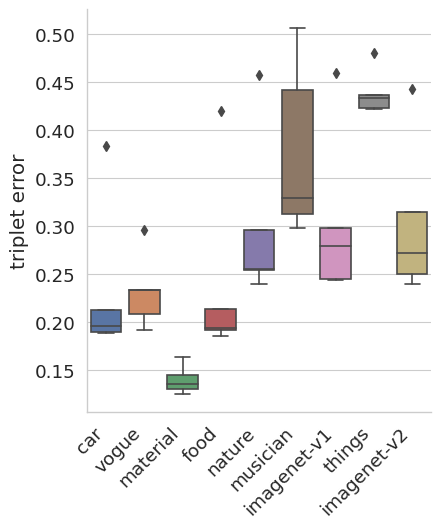

In [6]:
fg = sns.catplot(data=results.query('library == "cblearn" and not is_gpu').sort_values(by='n_objects'), 
                 x="dataset", y="error", kind="box") 
plt.xticks(rotation=45, horizontalalignment='right')
fg.set(ylabel='triplet error', xlabel='')
fg.savefig(plot_dir / f'error-per-dataset_cblearn.pdf')
fg.savefig(plot_dir / f'error-per-dataset_cblearn.png')

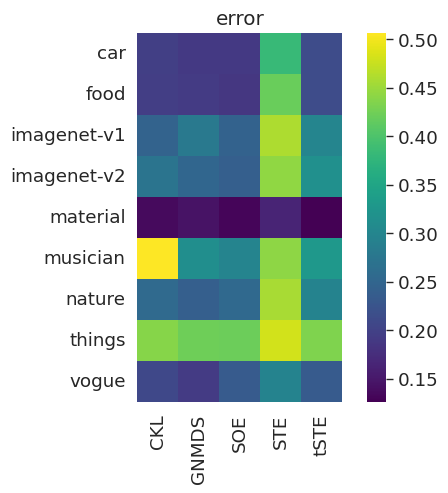

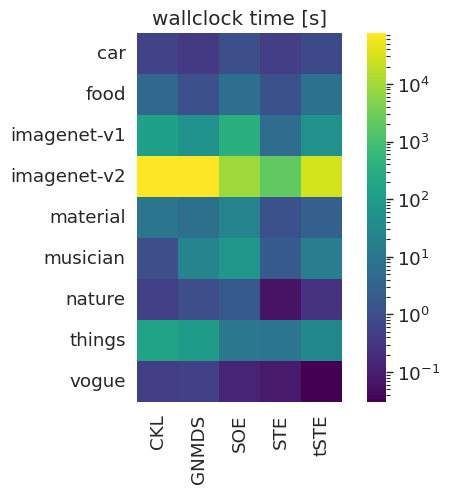

In [7]:
# long form to wide form to plot heatmap of errors
df = results.query('library == "cblearn" and not is_gpu').sort_values(by='n_objects')

sq_df = df.pivot(index='dataset', columns='algorithm', values='error')
ax = sns.heatmap(sq_df, annot=False, fmt='.2e', cmap='viridis', square=True)
ax.set(xlabel="", ylabel="", title='error')
plt.savefig(plot_dir / f'error-per-dataset-algorithm_cblearn.pdf')
plt.savefig(plot_dir / f'error-per-dataset-algorithm_cblearn.png')
plt.show()

sq_df = df.pivot(index='dataset', columns='algorithm', values='cpu_time')
ax = sns.heatmap(sq_df, annot=False, fmt='.2e', cmap='viridis', square=True, norm=LogNorm())
ax.set(xlabel="", ylabel="", title='wallclock time [s]')

plt.savefig(plot_dir / f'time-per-dataset-algorithm_cblearn.pdf')
plt.savefig(plot_dir / f'time-per-dataset-algorithm_cblearn.png')

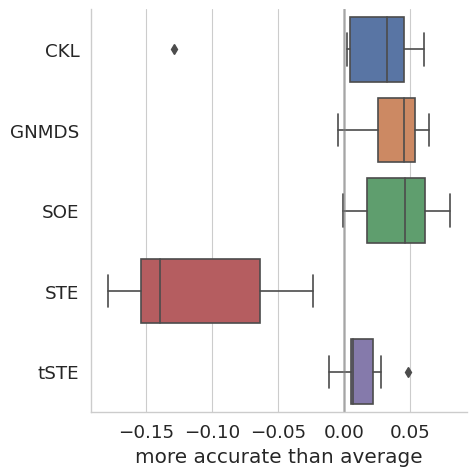

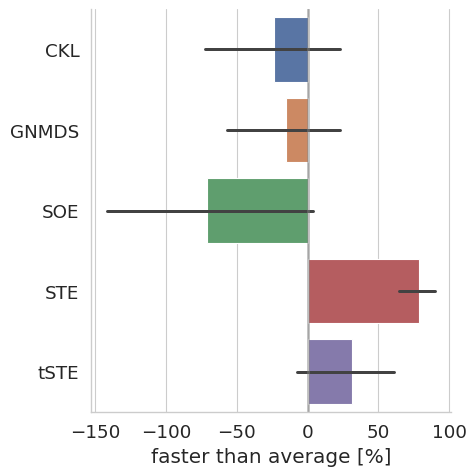

In [31]:
def plot_error_improvement(df, y='error', groupby='dataset', kind='box', orient='h', **kwargs):
    x = 'algorithm'
    raw_y = y
    y = f'rel_{raw_y}'
    if orient == 'h':
        x, y = y, x
    mean = df.groupby(groupby)[raw_y].transform('mean')
    df[f'rel_{raw_y}'] = mean - df[raw_y]
    fg = sns.catplot(data=df, x=x, y=y, kind=kind, **kwargs) 
    if orient == 'h':
        fg.set(xlabel=f"more accurate than average", ylabel='')
        fg.map(plt.axvline, x=0, color='grey', alpha=0.5, lw=2)
    else:
        fg.set(ylabel=f"more accurate than average", xlabel='')
        fg.map(plt.axhline, y=0, color='grey', alpha=0.5, lw=2)
    return fg

def plot_time_improvement(df, y='cpu_time', groupby='dataset', kind='bar', orient='h', **kwargs):
    x = 'algorithm'
    raw_y = y
    y = f'rel_{raw_y}'
    if orient == 'h':
        x, y = y, x
    mean = df.groupby(groupby)[raw_y].transform('mean')
    df[f'rel_{raw_y}'] = (mean - df[raw_y]) / mean * 100
    fg = sns.catplot(data=df, x=x, y=y, kind=kind, **kwargs) 
    if orient == 'h':
        fg.set(xlabel=f"faster than average [%]", ylabel='')
        fg.map(plt.axvline, x=0, color='grey', alpha=0.5, lw=2)
    else:
        fg.set(ylabel=f"faster than average [%]", xlabel='')
        fg.map(plt.axhline, y=0, color='grey', alpha=0.5, lw=2)
    return fg


df = results.query('library == "cblearn" and not is_gpu').copy(deep=True)

fg = plot_error_improvement(df)
fg.savefig(plot_dir / f'deltaerror-per-algorithm_cblearn.pdf')
fg.savefig(plot_dir / f'deltaerror-per-algorithm_cblearn.png')

fg = plot_time_improvement(df, y='cpu_time', kind='bar')
fg.savefig(plot_dir / f'deltatime-per-algorithm_cblearn.pdf')
fg.savefig(plot_dir / f'deltatime-per-algorithm_cblearn.png')

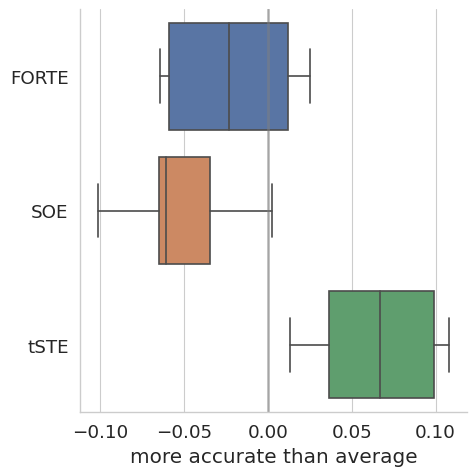

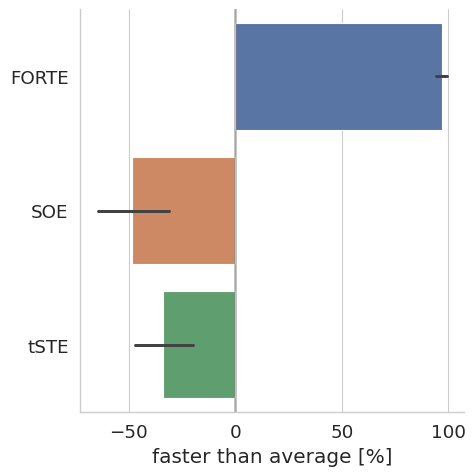

In [32]:
df = results.query('library == "cblearn" and is_gpu').copy(deep=True)
fg = plot_error_improvement(df)
fg.savefig(plot_dir / f'deltaerror-per-algorithm_cblearn-gpu.pdf')
fg.savefig(plot_dir / f'deltaerror-per-algorithm_cblearn-gpu.png')

fg = plot_time_improvement(df, y='cpu_time', kind='bar')
fg.savefig(plot_dir / f'deltatime-per-algorithm_cblearn-gpu.pdf')
fg.savefig(plot_dir / f'deltatime-per-algorithm_cblearn-gpu.png')

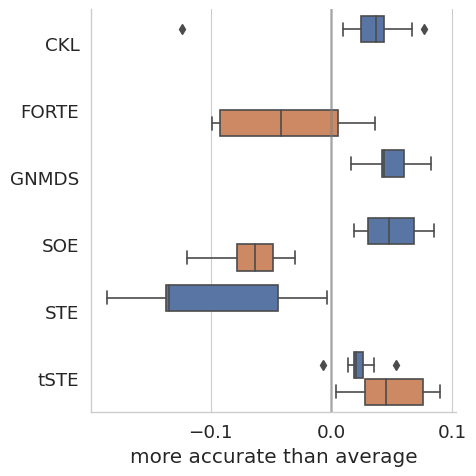

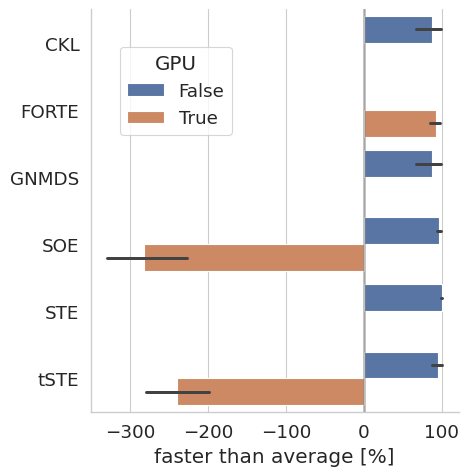

In [46]:
df = results.query('library == "cblearn"').copy(deep=True)
fg = plot_error_improvement(df, hue='is_gpu', orient='h', legend=False)
fg.set_titles('GPU = {col_name}')
fg.savefig(plot_dir / f'deltaerror-per-algorithm_cblearn-all.pdf')
fg.savefig(plot_dir / f'deltaerror-per-algorithm_cblearn-all.png')

fg = plot_time_improvement(df, hue='is_gpu')
fg.set_titles('GPU = {col_name}')
fg.legend.set_title('GPU')

sns.move_legend(fg, 'upper left', frameon=True, bbox_to_anchor=(0.2, 0.9))
fg.savefig(plot_dir / f'deltatime-per-algorithm_cblearn-all.pdf')
fg.savefig(plot_dir / f'deltatime-per-algorithm_cblearn-all.png')

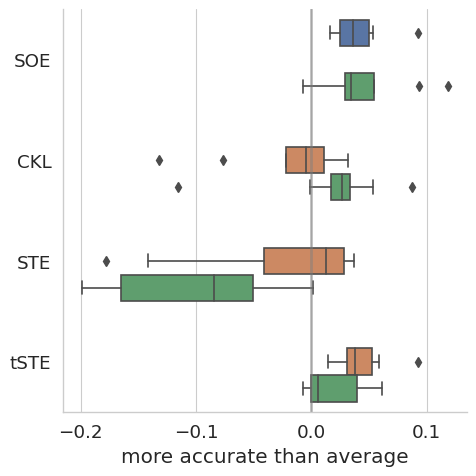

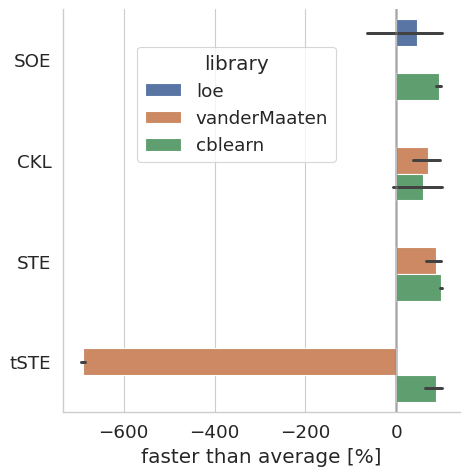

In [48]:
df = results[results.algorithm.isin(['SOE', 'STE', 'tSTE', 'CKL']) & ~results.is_gpu].copy(deep=True)
fg = plot_error_improvement(df, y='error', hue='library', legend=False) 
fg.savefig(plot_dir / f'deltaerror-per-algorithm_library.pdf')
fg.savefig(plot_dir / f'deltaerror-per-algorithm_library.png')
plt.show()

fg = plot_time_improvement(df, y='cpu_time', hue='library', kind='bar')
sns.move_legend(fg, 'upper left', frameon=True, bbox_to_anchor=(0.2, 0.9))
fg.savefig(plot_dir / f'deltatime-per-algorithm_library.pdf')
fg.savefig(plot_dir / f'deltatime-per-algorithm_library.png')

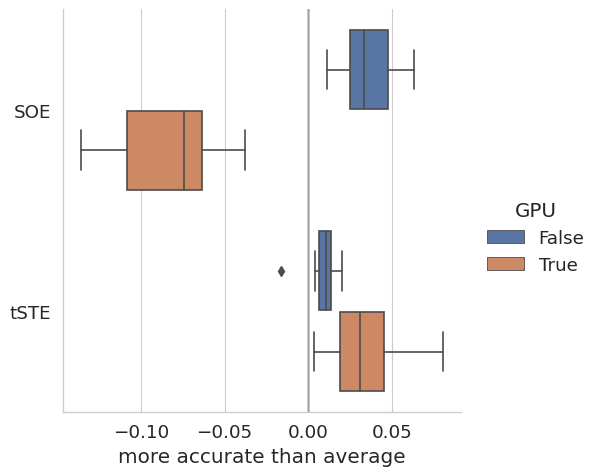

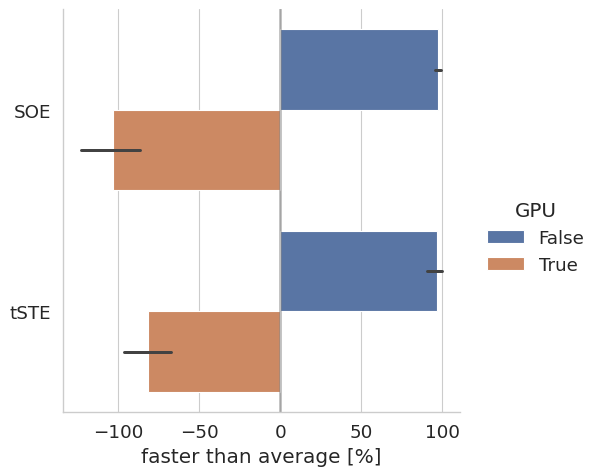

In [49]:
df = results[results.algorithm.isin(['SOE', 'SOE-GPU', 'tSTE', 'tSTE-GPU'])]
df = df[df.library == 'cblearn'].copy(deep=True)
fg = plot_error_improvement(df, y='error', hue='is_gpu', groupby=['dataset']) 
fg.legend.set_title('GPU')
fg.savefig(plot_dir / f'deltaerror-per-algorithm_gpu.pdf')
fg.savefig(plot_dir / f'deltaerror-per-algorithm_gpu.png')
plt.show()

fg = plot_time_improvement(df, y='cpu_time', hue='is_gpu', kind='bar', groupby=['dataset'])
fg.legend.set_title('GPU')
fg.savefig(plot_dir / f'deltatime-per-algorithm_gpu.pdf')
fg.savefig(plot_dir / f'deltatime-per-algorithm_gpu.png')

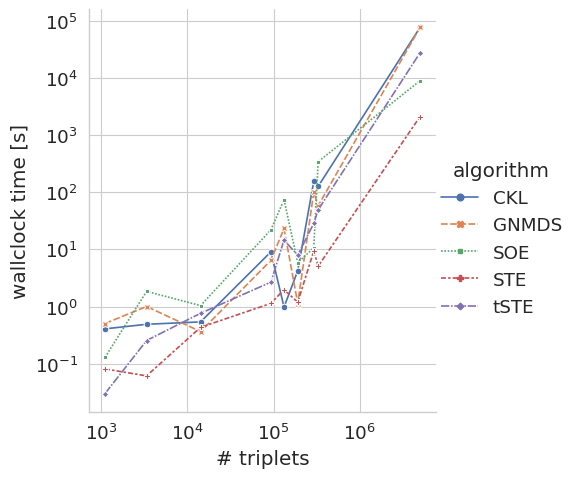

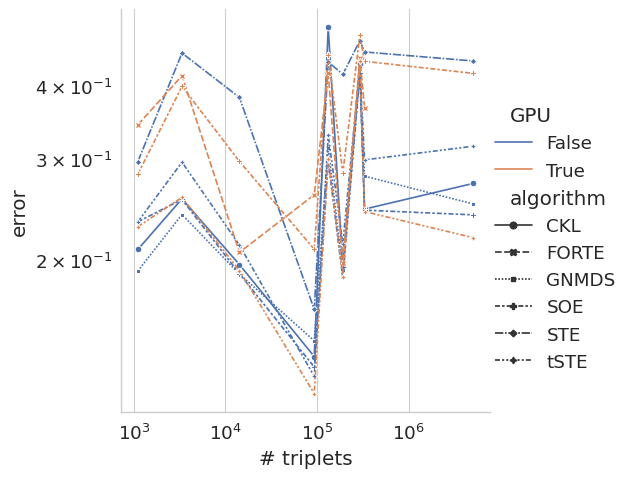

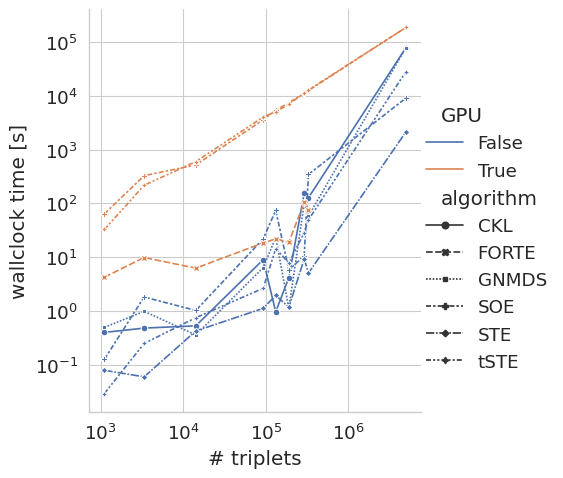

In [50]:
def plot_runtime(results, y='cpu_time', **kwargs):
    fg = sns.relplot(results, x='n_triplets', y=y, kind='line', dashes=True, markers=True, **kwargs)
    fg.set(xlabel='# triplets', ylabel='wallclock time [s]', xscale='log', yscale='log')
    return fg
# 
def plot_error(results, y='error', **kwargs):
    fg = sns.relplot(results, x='n_triplets', y=y, kind='line', dashes=True, markers=True, **kwargs)
    fg.set(xlabel='# triplets', ylabel='error', xscale='log', yscale='log')
    return fg


fg = plot_runtime(results.query('library == "cblearn" and not is_gpu'), hue='algorithm', style='algorithm')
fg.savefig(plot_dir / f'time-per-triplets_cblearn.pdf')
fg.savefig(plot_dir / f'time-per-triplets_cblearn.png')

fg = plot_error(results.query('library == "cblearn"').rename(columns={'is_gpu': 'GPU'}), hue='GPU', style='algorithm')
fg.savefig(plot_dir / f'error-per-triplets_gpu.pdf')
fg.savefig(plot_dir / f'error-per-triplets_gpu.png')

fg = plot_runtime(results.query('library == "cblearn"').rename(columns={'is_gpu': 'GPU'}), hue='GPU', style='algorithm')
fg.savefig(plot_dir / f'time-per-triplets_gpu.pdf')
fg.savefig(plot_dir / f'time-per-triplets_gpu.png')